# Neural network prediciting Forest fires

In this project, I will build youra regression neural network and use it to predict Forest fires.

In [6]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pandas as pd
import matplotlib as plt


# Loading and preparing data

Here i load my data and try to get the appropriate scale for it

In [40]:
data_path = 'Forest-Fire-Dataset/forestfires.csv'
fires = pd.read_csv(data_path)

In [41]:
fires.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [46]:
#Encode data
fires.month.replace(('jan', 'feb','mar', 'apr','may', 'jun', 'jul','aug', 'sept', 'oct', 'nov', 'dec')
                    ,(1,2,3,4,5,6,7,8,9,10,11,12), inplace=True)
fires.day.replace(('mon','tue','wed','thu','fri','sat', 'sun'),(1,2,3,4,5,6,7), inplace=True)

#fires["area"] = np.log(fires["area"] + 1)
#fires.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,3,5,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,10,2,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,10,6,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,3,5,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,3,7,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


# Dummy Variables

To be able to include categorical variables like day and month in my model, they have to be turned into binary dummy variables. This can be done with Pandas using get_dummies().

In [51]:
dummy_fields = ['day', 'month']
for each in dummy_fields:
    dummies = pd.get_dummies(fires[each], prefix=each, drop_first=False)
    fires = pd.concat([fires, dummies], axis =1)
    
fields_to_drop = ['day', 'month']
data = fires.drop(fields_to_drop, axis=1)
data.head()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,month_3,month_4,month_5,month_6,month_7,month_8,month_10,month_11,month_12,month_sep
0,7,5,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,...,1,0,0,0,0,0,0,0,0,0
1,7,4,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,...,0,0,0,0,0,0,1,0,0,0
2,7,4,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,...,0,0,0,0,0,0,1,0,0,0
3,8,6,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,...,1,0,0,0,0,0,0,0,0,0
4,8,6,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,...,1,0,0,0,0,0,0,0,0,0


Applying ln(x+1) to area as suggested in the article

In [52]:
fires["area"] = np.log(fires["area"] + 1)

# Checking out the data

## FWI Fuel Moisture Codes

There are 3 fuel moisture categories, or codes, in the FWI system, compared to 7 found in NFDRS. These are generally represented as unitless codes instead of fuel moisture content (represented as a % of dry weight).  They can be converted to moisture content, and in fact, are converted each day as part of the daily or hourly calculations.

The Fine Fuel Moisture Code (FFMC) represents fuel moisture of forest litter fuels under the shade of a forest canopy. It is intended to represent moisture conditions for shaded litter fuels, the equivalent of 16-hour timelag. It ranges from 0-101. Subtracting the FFMC value from 100 can provide an estimate for the equivalent (approximately 10h) fuel moisture content, most accurate when FFMC values are roughly above 80. 

The Duff Moisture Code (DMC) represents fuel moisture of decomposed organic material underneath the litter. System designers suggest that it is represents moisture conditions for the equivalent of 15-day (or 360 hr) timelag fuels. It is unitless and open ended. It may provide insight to live fuel moisture stress.

The Drought Code (DC), much like the Keetch-Byrum Drought Index, represents drying deep into the soil. It approximates moisture conditions for the equivalent of 53-day (1272 hour) timelag fuels. It is unitless, with a maximum value of 1000. Extreme drought conditions have produced DC values near 800.

This example plot of all three moisture codes through a fire season demonstrates how fuel moisture codes rise as fuels dry out, and falls with precipitation and (primarily with FFMC) with moderating weather.

from http://www.fbfrg.org/cffdrs/fire-weather-index-fwi-system


## FWI Fire Behavior Indices

There are 3 fire behavior indices in the FWI system:

The Initial Spread Index (ISI) is analogous to the NFDRS Spread Component (SC). It integrates fuel moisture for fine dead fuels and surface windspeed to estimate a spread potential. ISI is a key input for fire behavior predictions in the FBP system. It is unitless and open ended. 

The Buildup Index (BUI) is analogous to the NFDRS Energy Release Component (ERC). It combines the current DMC and DC to produce an estimate of potential heat release in heavier fuels. It is unitless and open ended. In Alaska and the Lake States, it is the primary indicator of season severity during the growing season. 

The Fire Weather Index (FWI) integrates current ISI and BUI to produce a unitless index of general fire intensity potential. It is analogous to NFDRS Burning Index. With dry fuel conditions, it is a key indicator of extreme fire behavior potential. Again, unitless and open ended.

from http://www.fbfrg.org/cffdrs/fire-weather-index-fwi-system



1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9 
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9 
3. month - month of the year: 'jan' to 'dec' 
4. day - day of the week: 'mon' to 'sun' 
5. FFMC - FFMC(Fine fuel moisture code) index from the FWI(Fire weather index) system: 18.7 to 96.20 
6. DMC - DMC(Duff Moisture Code) index from the FWI system(Fire weather index): 1.1 to 291.3 
7. DC - DC(Drought Code) index from the FWI(Fire weather index) system: 7.9 to 860.6 
8. ISI - ISI(Initial Spread Index) index from the FWI (Fire weather index) system: 0.0 to 56.10 
9. temp - temperature in Celsius degrees: 2.2 to 33.30 
10. RH - relative humidity in %: 15.0 to 100 
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84


/Users/jimiadekoya/anaconda/envs/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_base.py:3124: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  'left=%s, right=%s') % (left, right))


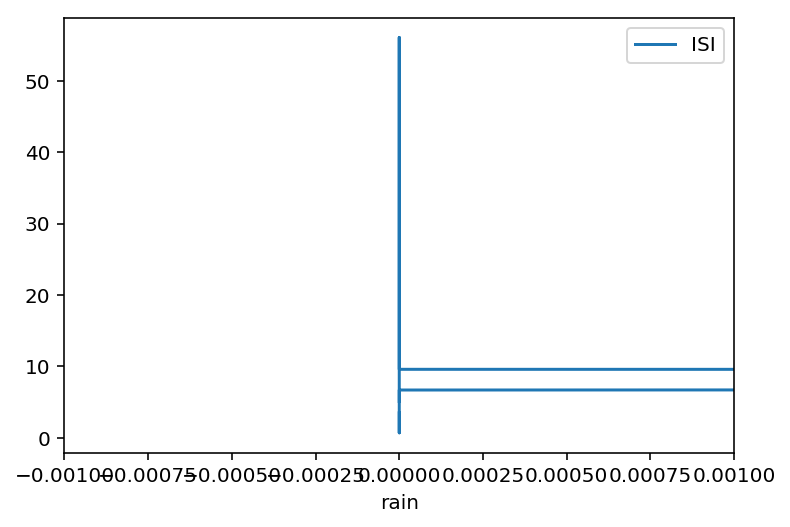

In [45]:
fires[:24*10].plot(x="rain", y="ISI")

# scaling target variable

To make training the network easier, the continuous variables are standardized. The variables shifted and scaled such that they have zero mean and a standard deviation of 1.

In [55]:
quant_features = ['X','Y','FFMC','DMC','DC','ISI', 'temp','RH','wind', 'rain','area']
#Store scalings in dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] =(data[each] - mean)/std